# Lab 3 - Logistic Regression

In this lab we implement and use logistic regressione for binary claffication problems.

We start including some libraries and functions already seen in the previous labs (or slight variations of them). Have a look and verify you understand their purpose.

<b>READ all the text parts very carefully, as you will find instructions on how to proceed.</b>

In [1664]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [1665]:
from numpy.random import Generator


def _check_random_generator(rng: int | Generator | None) -> Generator:
    """Convert rng into a np.random.Generator instance."""
    if rng is None:
        print("⚠️  Warning: Set the `rng` parameter to a NumPy random generator\n"
              "   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure\n"
              "   your results are reproducible. Proceeding with a random seed for now.")
        return np.random.default_rng()
    if isinstance(rng, np.random.Generator):
        return rng
    if isinstance(rng, (int, np.integer)):
        return np.random.default_rng(rng)


def mixGauss(means, sigmas, n, rng=None):
    """
    means : 2D array (num_classes, d)
        Each row of the array gives the mean of the Gaussian in multiple dimensions for one class.
        For binary classification problems, the number of rows should be 2!
    sigmas : 1D array (num_classes)
        The standard deviation for the Gaussian distribution of each class (isotropic Gaussian!)
    n : int (num_elements)
        Number of samples to generate

    Example:
 
    >>> means = [[3, 0], [0, 0]]
    >>> sigmas = [0.5, 1]
    >>> X, Y = mixGauss(means, sigmas, n=100)
    >>> fig, ax = plt.subplots()
    >>> ax.scatter(X[Y == 1,0], X[Y == 1,1], marker='o', color='r')
    >>> ax.scatter(X[Y == -1,0], X[Y == -1,1], marker='o', color='b')
    """
    rng = _check_random_generator(rng)

    means = np.asarray(means)
    sigmas = np.asarray(sigmas)

    num_classes = sigmas.shape[0]
    assert means.shape[0] == num_classes, "Number of `means` and `sigmas` should be the same."

    d = means.shape[1]
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes, dtype=np.int64)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = rng.multivariate_normal(
            mean=means[idx], cov=np.eye(d) * sigma ** 2, size=n)
        labels[idx * n:(idx + 1) * n] = idx

    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.


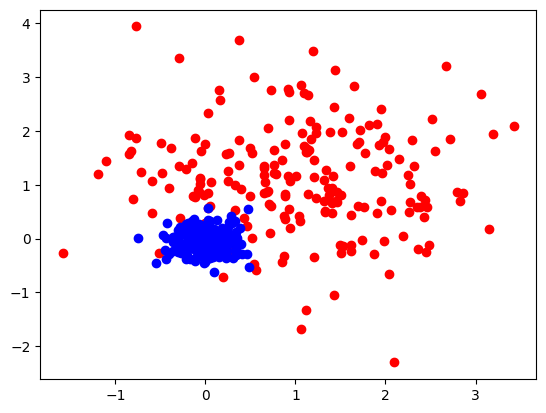

In [1666]:
# visualize random dataset
X, Y = mixGauss([[1, 1], [0, 0]], [1, 0.2], n=200)
plt.scatter(X[Y==-1, 0], X[Y==-1, 1], c='r')
plt.scatter(X[Y==1, 0], X[Y==1, 1], c='b');
plt.show();

In [1667]:
def flipLabels(Y, perc, rng=None):
    assert 0 <= perc <= 100, "`perc` should be a percentage value between 0 and 100."
    assert all(np.abs(Y) == 1), "The values of Ytr should be +1 or -1."

    Y_noisy = np.copy(np.squeeze(Y))
    assert Y_noisy.ndim == 1, "Please supply a label array with only one dimension"
    n = Y_noisy.shape[0]

    rng = _check_random_generator(rng)
    n_flips = int(np.floor(n * perc / 100))
    idx_to_flip = rng.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

## Linear logistic regression with gradient descent

We define two functions:
 - the `optimal_gd_learning_rate(Xtr, reg_par)` function calculates the optimal learning rate for GD on a given dataset. You will need to use the SVD of the covariance matrix.
 - the `train_logreg_gd(Xtr, Ytr, reg_par, maxiter)` function estimates the classifier weights on the training set.

<br>

The parameters of the `optimal_gd_learning_rate` function are:
- <b>Xtr</b> is the nxD matrix of training set inputs
- <b>reg_par</b> is the value of the lammbda

and it should output the learning rate $\gamma$ (a scalar).
You should use the `np.linalg.eigvalsh` function to calculate the eigenvalues of the covariance matrix.

<br>

The parameters of the `train_logreg_gd` function are:
- <b>Xtr</b> is the nxD matrix of training set inputs
- <b>Ytr</b> is the n vector of training set outputs
- <b>reg_par</b> is the value of the lammbda
- <b>maxiter</b> is the maximum number of iterations to run gradient descent

and it should output:
- <b>w</b> is the D vector of the estimated function parameters
- <b>losses</b> is the vector of the loss at each iteration


In [1668]:
# Estimate the gamma parameter: the optimal learning rate for gradient descent
def optimal_gd_learning_rate(Xtr, reg_par):
    eigvals = np.linalg.eigvalsh(Xtr.T @ Xtr)
    # Calculate L: the Lipschitz constant of the gradient
    L = np.max(eigvals) / Xtr.shape[0] + 2 * reg_par
    gamma = 1 / L
    return gamma

In [1669]:
def train_logreg_gd(Xtr, Ytr, reg_par, epsilon = 1e-6, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    epsilon :  the tolerance for the stopping criterion
    maxiter : the maximum number of gradient-descent iterations
    """
    # size of the input in the training
    n, D = np.shape(Xtr)

    # initialization of the vector w
    w = np.zeros((D, 1))

    # Set the learning rate optimally
    gamma = optimal_gd_learning_rate(Xtr, reg_par)

    # initialization of some supporting variables
    j = 0
    loss_old = 0
    loss = float("inf")
    training_losses = np.zeros(maxiter + 1) 
    Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1
    while j < maxiter and abs(loss - loss_old) >= epsilon:
        loss_old = loss

        # TODO: Update the weights
        z = Xtr @ w
        w = w - gamma * ((Xtr.T @ (1 / (1 + np.exp(-z)) - (Ytr + 1)/2)) / n + 2 * reg_par * w)
    

        # TODO: Compute the loss
        loss = (np.mean(np.log(1 + np.exp(-Ytr * z)))) + (reg_par * np.sum(w ** 2))

        training_losses[j] = loss
        j = j + 1
    return w, training_losses[:j]

### Evaluation the function on the test set

A function to perform predictions on a set of samples given the learned logistic regression weights

##### Ypred, Ppred = predict_logreg(weights, Xte)
where
- <b>weights</b> is the D vector of the estimated function parameters
- <b>X</b> is the matrix of input points of the training or test set.
- <b>Ypred</b> is the vector of predictions
- <b>Ppred</b> is the predicted probability of a point belonging to class +1. It will be 0 if the model is very confident the point belongs to class -1, it will be 1 if the model is very confident that the point belongs to class +1.

In [1670]:
def predict_logreg(weights, X):
    """
    weights : array of shape d, 1
    X : array of shape n, d
    """
    ypred = np.dot(X, weights)
    # TODO: Try and understand what it does, deriving the formula
    ppred = 1 / (1 + np.exp(-ypred))
    # The outputs are reshaped to be 1D vectors
    return np.sign(ypred).reshape(-1), ppred.reshape(-1)

In [1671]:
def calcError(Ypred, Y):
    return np.mean(Ypred != Y)

## Initial Analysis

Perform the following tasks for the initial analysis:

1. Create two binary classification datasets (training and test sets) -- Use the same parameters. Visualize them in a scatter plot.

2. Pick a reasonable value for lambda (e.g. reg_par = 0.1, 0.01, 0.001, ...) and train a logistic-regression model using the functions you have defined.

3. Plot the loss at each iteration which is returned by the training function. The loss should decrease at each iteration, **if the loss does not decrease there is an error in the implementation!**

4. Use the `separatingFLR` function to plot the separating curve obtained with the model

5. Evaluate the error training and test sets.

**Important #1**: The parameters used to generate the data are quite important. Try to make sure that the two classes are distinct (i.e. the means of the Gaussians should be different), but also not too far. Ideally a few points should overlap between the classes.
Make sure to generate at least 100 points for both train and test sets.

**Important #2**: since we are implementing a linear model, we must add a bias term -- otherwise the weights will draw a line which always goes through 0. An alternative to adding a bias term to the model is to add a feature comprising all ones to the data-column. We can use the following code for this:
```
Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))
```
what whill be the resulting shape of the weight vector `w`?

In [1672]:
# Visualize the separating curve for the calculated weights w
def separatingFLR(Xtr, Ytr, w):
    x1min, x1max = min(Xtr[:, 0]), max(Xtr[:, 0])
    x2min, x2max = min(Xtr[:, 1]), max(Xtr[:, 1])

    # Number of meshpoints for visualization
    Nx1, Nx2 = 1000, 1000
    x1mesh = np.linspace(x1min, x1max, Nx1)
    x2mesh = np.linspace(x2min, x2max, Nx2)

    # Create mesh and reshape x1 and x2 into a single array of points
    x1, x2 = np.meshgrid(x1mesh, x2mesh)
    meshpoints = np.column_stack((x1.ravel(), x2.ravel()))
    meshpoints_bias = np.hstack((meshpoints, np.ones((meshpoints.shape[0], 1))))

    # TODO: Calculate the predicted labels for `meshpoints_bias`
    ypred = predict_logreg(w, meshpoints_bias)[0]
    ymesh = np.reshape(ypred, (Nx2, Nx1))
    
    # Plot data points
    _, ax = plt.subplots()
    ax.contour(x1mesh, x2mesh, ymesh, levels=[0], colors='red')
    ax.scatter(Xtr[:,0], Xtr[:,1], s=70, c=Ytr, alpha=0.8)
    ax.set_aspect('equal')
    plt.show();

⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.
⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.


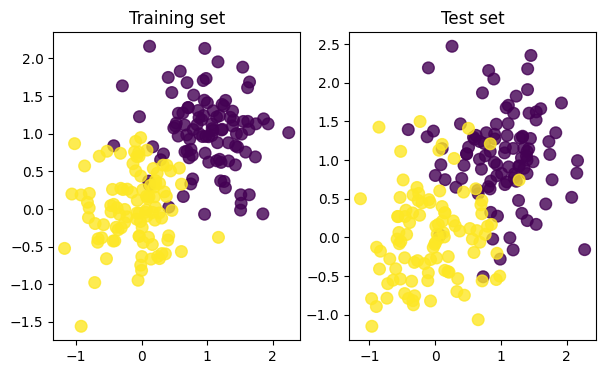

In [1673]:
# Help for data-generation
means = [[1, 1], [0, 0]]
sigmas = [0.5, 0.5]

Xtr, Ytr = mixGauss(means, sigmas, n=100)
Xts, Yts = mixGauss(means, sigmas, n=100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

# TODO: Plot training and test sets, coloring the two classes differently.
fig = plt.figure(figsize=(7, 4))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

ax0.set_title("Training set")
ax0.scatter(Xtr[:,0], Xtr[:,1], s=70, c=Ytr, alpha=0.8)

ax1.set_title("Test set")
ax1.scatter(Xts[:,0], Xts[:,1], s=70, c=Yts, alpha=0.8)

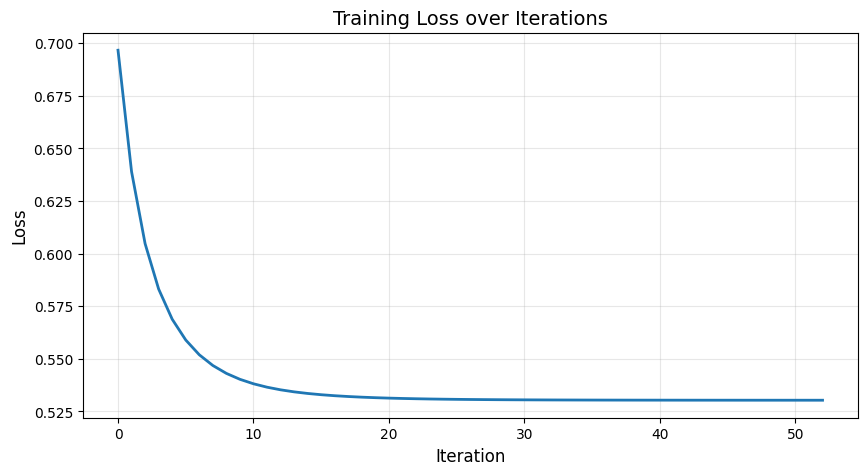

Training converged after 53 iterations
Final loss: 0.530309


In [1674]:
# TODO: Plot the losses
# Train the logistic regression model
reg_par = 0.1  
w, losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par, maxiter=1000)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss over Iterations', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Training converged after {len(losses)} iterations")
print(f"Final loss: {losses[-1]:.6f}")


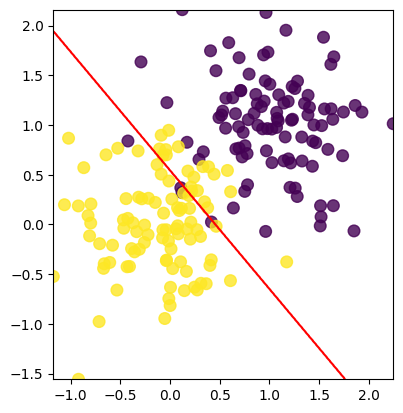

In [1675]:
# TODO: Plot the separating curve (on the test set)
separatingFLR(Xtr, Ytr, w)

In [1676]:
# TODO: Evaluate the errors
tr_pred, _ = predict_logreg(w, Xtr_wbias)
tr_err = calcError(tr_pred, Ytr)
ts_pred, _ = predict_logreg(w, Xts_wbias)
ts_err = calcError(ts_pred, Yts)
print(f"Training error: {tr_err*100:.2f}, Test error: {ts_err*100:.2f}")

Training error: 12.00, Test error: 12.50


## Interpreting the confidence of logistic regression predictions

Logistic regression does not only output *pointwise predictions* (the class to which a point belongs), but it also gives the **probability** that a test point belongs to a certain class.

This probability can be very useful to interpret the outputs of your model: in certain cases it might be better to **not predict anything** if the confidence of the model is low (i.e. if the model predicts a probability of 0.5 in a binary setting, the model is not sure which class a point belongs to).

In this part of the lab, we will
 1. Implement a function which allows to visualize the confidence of predictions (`plot_logreg_confidence`)
 2. Train a logistic regression model, and use the visualization function to see where the low confidence region of prediction lies.
 3. Calculate the error on **just the high-confidence** predictions, and see how the it changes.

In [1677]:
def plot_logreg_confidence(X, Y, pred_confidence, threshold):
    """
    X : a (n, d) dataset
    Y : a (n, ) array of targets
    pred_confidence : A (n, ) array of probabilities predicted from X
    threshold : a float between 0 and 0.5 determining the probability threshold we use to 
                consider neutral predictions. For example if threshold=0.1 then all probabilities
                between 0.4 and 0.6 will be considered neutral (that is, neither belonging to class +1
                or to class -1).
    """
    _, ax = plt.subplots()
    xi = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
    yi = np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
    X_grid, Y_grid = np.meshgrid(xi,yi)

    zi = griddata(X, pred_confidence, (X_grid, Y_grid), method='linear')

    ax.contour(xi, yi, zi, 15, linewidths=2, levels=[0.5 - threshold, 0.5 + threshold])

    # Plot data points
    ax.scatter(X[:,0], X[:,1], c=Y, marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(X[:,0].min(), X[:,0].max())
    ax.set_ylim(X[:,1].min(), X[:,1].max())
    plt.show();

In [1678]:
# Generate some data
Xtr, Ytr = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)
Xts, Yts = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.
⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.


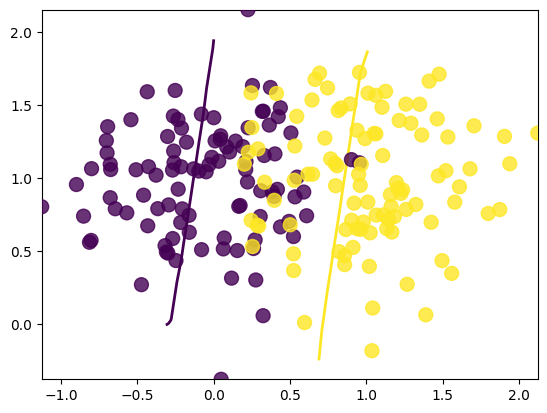

In [1679]:
# TODO: Train a logistic regression model, and obtain the probability predictions for the test set
reg_par = 0.1  
w, losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par, maxiter=1000)
ts_pred, ts_conf = predict_logreg(w, Xts_wbias)
# TODO: Plot the logistic regression confidence for different thresholds. Interpret what you see.
plot_logreg_confidence(Xts, Yts, ts_conf, threshold=0.1)

In [1680]:
def calc_error_with_confidence(prob_pred, Y, threshold):
    """
    Calculate the classification error on only the predictions with a high confidence!
    """
    class_m1 = prob_pred <= 0.5 - threshold
    class_p1 = prob_pred > 0.5 + threshold

    err_class_m1 = Y[class_m1] != -1
    err_class_p1 = Y[class_p1] != 1
    return (np.sum(err_class_m1) + np.sum(err_class_p1)) / (len(err_class_m1) + len(err_class_p1))

In [1681]:
# TODO: Train a log-reg model, and calculate the error on only the high-confidence examples from the test
#       set. How do you expect this error to behave as you change the threshold?
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4]
for threshold in thresholds:
    err = calc_error_with_confidence(ts_conf, Yts, threshold)
    print(f"Threshold: {threshold:.2f}, Test error on high-confidence examples: {err*100:.2f}%")

Threshold: 0.00, Test error on high-confidence examples: 14.00%
Threshold: 0.10, Test error on high-confidence examples: 1.79%
Threshold: 0.20, Test error on high-confidence examples: 0.00%
Threshold: 0.30, Test error on high-confidence examples: 0.00%
Threshold: 0.40, Test error on high-confidence examples: nan%


C:\Users\Mario\AppData\Local\Temp\ipykernel_14684\808770195.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum(err_class_m1) + np.sum(err_class_p1)) / (len(err_class_m1) + len(err_class_p1))


as thresholds increase confidence decreases.

## Logistic Regression with Stochastic Gradient Descent

SGD is quite similar to GD, but instead of updating the weights with the gradient of all the training samples at once, at each step it updates the weights with the **gradient of a single sample** picked at random from the training set.

Since at each iteration it uses a single sample it will be much faster, but it will need more iterations.

In this last part you will:
 1. Implement a SGD solver for logistic regression
 2. Use it to learn a logistic-regression model
 3. Compare the results to learning with GD.

In [1682]:
def train_logreg_sgd(Xtr, Ytr, reg_par, epsilon = 1e-6, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    epsilon :  the tolerance for the stopping criterion
    maxiter : the maximum number of gradient-descent iterations
    """
    # size of the input in the training
    n, D = np.shape(Xtr)
    # initialization of the vector w
    w = np.zeros((D, 1))
    
    # initialization of some supporting variables
    training_losses = np.zeros(maxiter)
    Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1
    for j in range(maxiter):
        # The learning rate here is different from GD. You can take
        # a) 1 / sqrt(n)
        # b) 1 / sqrt(j) : the learning rate decreases at each iteration.
        # Which one do you expect leads to faster convergence?
        gamma = 1 / np.sqrt(n)

        # TODO: Choose the sample current sample from Xtr **at random**
        sample_idx = np.random.randint(0, n)
        x_i = Xtr[sample_idx:sample_idx+1, :] 
        y_i = Ytr[sample_idx:sample_idx+1, :]  

        # TODO: Use the formulas from the slides to update the weight vector    
        w = w - gamma * (-(1 - (1 / (1 + np.exp(-y_i * (x_i @ w))))) * y_i * x_i.T + 2 * reg_par * w)

        # TODO: Calculate the loss on the current sample
        loss = np.mean(np.log(1 + np.exp(-Ytr * (Xtr @ w)))) + reg_par * np.sum(w**2)
        training_losses[j] = loss

        if j > 0 and abs(training_losses[j] - training_losses[j-1]) < epsilon:
            break

    return w, training_losses[:j]

In [1683]:
# TODO: Generate a dataset (use the code from the previous parts)
Xtr, Ytr = mixGauss([[1, 1], [0, 0]], [1, 0.2], n=200)
Xts, Yts = mixGauss([[1, 1], [0, 0]], [1, 0.2], n=200)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.
⚠️  Warning: Set the `rng` parameter to a NumPy random generator
   (e.g. `np.random.default_rng(42)`) or specify a fixed seed to ensure
   your results are reproducible. Proceeding with a random seed for now.


In [1684]:
# TODO: Train logistic regression with SGD
reg_par = 0.1
sgd_w, sgd_losses = train_logreg_sgd(Xtr_wbias, Ytr, reg_par, maxiter=10000)

# TODO: Train logistic regression with GD  
gd_w, gd_losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par, maxiter=1000)

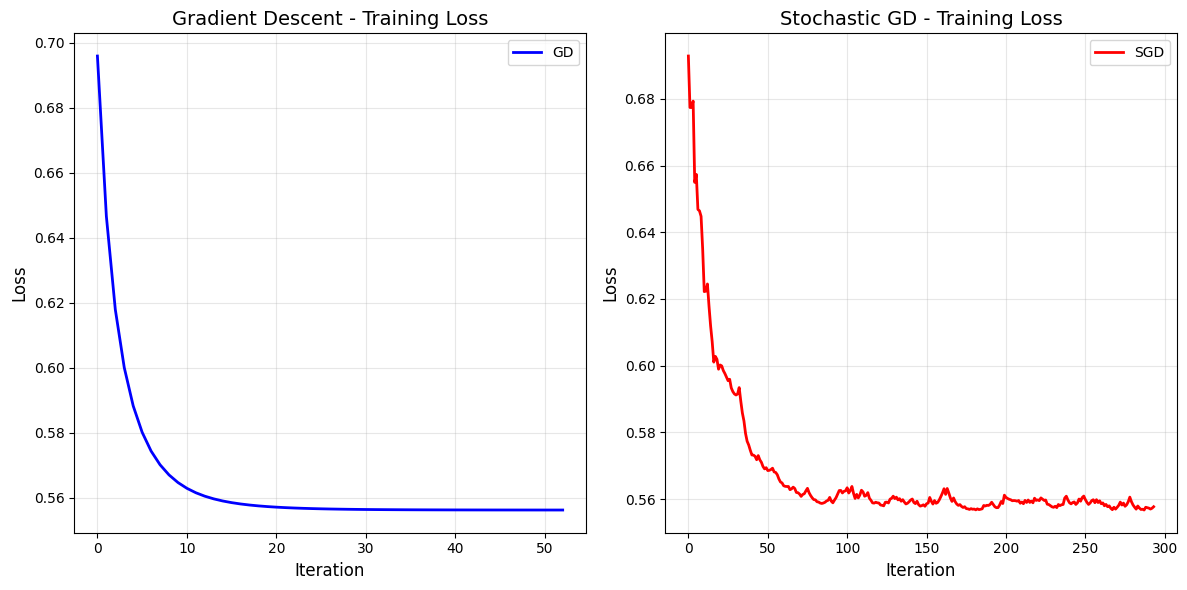

SGD converged after 294 iterations
SGD final loss: 0.557704
GD converged after 53 iterations
GD final loss: 0.556228
SGD - Test error: 9.75%
GD  - Test error: 9.25%


In [1685]:
# TODO: Compare the two in terms of:
#  1. number of iterations needed to converge (keep in mind that GD iterations cost n times more)
#  2. accuracy.

# Plot the losses for comparison
plt.figure(figsize=(12, 6))

# Plot GD losses
plt.subplot(1, 2, 1)
plt.plot(gd_losses, linewidth=2, color='blue', label='GD')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Gradient Descent - Training Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()


# Plot SGD losses
plt.subplot(1, 2, 2)
plt.plot(sgd_losses, linewidth=2, color='red', label='SGD')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Stochastic GD - Training Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()


plt.tight_layout()
plt.show()

print(f"SGD converged after {len(sgd_losses)} iterations")
print(f"SGD final loss: {sgd_losses[-1]:.6f}")

print(f"GD converged after {len(gd_losses)} iterations") 
print(f"GD final loss: {gd_losses[-1]:.6f}")

# Calculate accuracy for both methods
# SGD predictions
sgd_ts_pred, _ = predict_logreg(sgd_w, Xts_wbias)
sgd_ts_err = calcError(sgd_ts_pred, Yts)

# GD predictions
gd_ts_pred, _ = predict_logreg(gd_w, Xts_wbias)
gd_ts_err = calcError(gd_ts_pred, Yts)

print(f"SGD - Test error: {sgd_ts_err*100:.2f}%")
print(f"GD  - Test error: {gd_ts_err*100:.2f}%")

SGD e GD achieve similar test errors, but SGD converges in many more iterations.